In [46]:
# Do lane detection  by find lane & vehicle pixels using CNNs


In [1]:
import cv2
from glob import glob
import numpy as np
import tensorflow as tf

from keras.layers.convolutional import Convolution2D
from keras.layers.core import Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, model_from_json
from keras.regularizers import l2
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip

/home/gokul/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/gokul/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/gokul/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gokul/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.

In [2]:
# Calibration constants
mtx = np.array([[1.15777942e+03, 0.00000000e+00, 6.67111050e+02],
       [0.00000000e+00, 1.15282305e+03, 3.86129068e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
dist = np.array([[-0.24688832, -0.02372817, -0.00109843,  0.00035105, -0.00259133]])

In [3]:
def vidRead(vidtype, path ="/home/gokul/Projects/LaneDetection/Input/"):
    imgs = []
    if vidtype == 'Challenge':
        video = path + 'challenge_video.mp4'
    elif vidtype == 'Project':
        video = path + 'project_video.mp4'
    else:
        print('Improper video type')
    cap = cv2.VideoCapture(video)
    while(True):
        ret, frame = cap.read()
        if ret:
#             frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
            frame =  cv2.undistort(frame, mtx, dist, None, mtx)
            imgs.append(frame)
        else:
            break
    cap.release()
    
    return imgs

imgs = vidRead('Challenge')

In [4]:
video = '/home/gokul/Projects/LaneDetection/LaneDetect_cnn/challenge_video.mp4'
cap = cv2.VideoCapture(video)
ret,frame = cap.read()

height,width = frame.shape[:2]
## lane crop:
laneParams = {'y_min' : 420 ,'y_max': 666,
'x_min':200, 'x_max' : width-200,
'scaling' : 2, 'presence_weight': 50.0}

carParams = {'y_min' : 420 ,'y_max': 666,
'x_min':0, 'x_max' : width-200,
'scaling' : 2, 'presence_weight': 50.0}

In [7]:
Lanemodel = CarLaneModel(laneParams)
Lanemodel.load_weights('/home/gokul/Projects/LaneDetection/LaneDetect_cnn/models/lanes.h5')

Carmodel = CarLaneModel(laneParams)
Carmodel.load_weights('/home/gokul/Projects/LaneDetection/LaneDetect_cnn/models/cars.h5')

In [9]:
# Functions for Lane Detection using CNNs:

In [8]:
def preprocess(im,params):
    im = im[params['y_min']:params['y_max'],params['x_min']:params['x_max']] # crop the road
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) # convert to RGB
    im = cv2.resize(im, None, fx=(1.0/params['scaling']), fy=(1.0/params['scaling']),interpolation=cv2.INTER_AREA) # perform scaling
    low,high = np.amin(im), np.amax(im)  # find the min and max
    im = (((im - low + 1.0) * 252.0 / (high - low)) - 0.5).astype(np.uint8) # whitebalance correction

    im = cv2.GaussianBlur(im, (3,3), 0) # smoothen with gaussian blur
    im = cv2.normalize(im, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F) # normalize to 0,1

    return im

def getLaneMask(frame,Lanemodel,params):
    black = np.zeros_like(frame[:,:,0]).astype(np.float32)

    im = preprocess(frame,params)[None,:,:,:] # crop the lower road part, scale and make it 4D to fit the model's input shape  

    out = Lanemodel.predict(im) # perform the prediction from loaded model
    out = np.squeeze(out) # reshape to (h,w)
    out= cv2.resize(out, None, fx=params['scaling'], fy=params['scaling'])
    black[laneParams['y_min']:laneParams['y_max'], laneParams['x_min']:laneParams['x_max']] = out
    ret,out = cv2.threshold(black,0.5,1,cv2.THRESH_BINARY)
    del black,im

    return out

# to get birds eye view
def getPerspectiveTransform(im,inverse=False):
    im_warp = np.copy(im)
    height,width = im.shape[:2]

    a = 150
    horizon = 450
    b = 0.46
    pts = np.array([[a,height],[int(width*b),horizon],[int(width*(1-b)),horizon], [width-a, height]], np.float32)
#     res = np.array([[(a+100), height], [(a+100), 0], [width-(a+100), 0], [width-(a+100), height]], np.float32)
    res = np.array([[a, height], [a, 0], [width-a, 0], [width-a, height]], np.float32) 

    if inverse == True:
        M = cv2.getPerspectiveTransform(res, pts)
    else:   
        M = cv2.getPerspectiveTransform(pts, res)

    im_warp = cv2.warpPerspective(im_warp, M, (width,height), flags=cv2.INTER_LINEAR)
    
    return im_warp

# plot the tracked lane lines in the Map
def drawLaneLines(im_warp,L_line,R_line):

    imlines = im_warp.copy() # get a 
    im_lines = np.dstack((imlines,imlines,imlines))*255
    imlines = cv2.polylines(imlines, [L_line], False,  (255, 100,0), 30)
    imlines = cv2.polylines(imlines, [R_line], False,  (255, 100,0), 30)
    
    return imlines

# Track the lane lines by in bird's eye view image to find trajectory points using centroids
def windowTrace(im_warp, n_windows = 10, W_win = 100):
    
    # define window size parameters
    height,width = im_warp.shape[:2]
    H_win = int(height//n_windows) 


#     half_height = int(height//2) # divide the height by 2    
#     im_warpBOTTOM = im_warpBOTTOM[height:,:] # find bottom half of the warped road (B-map)

    distribution = np.sum(im_warp,axis=0) # plot the pixel distribution along x axis
    mdpt = int(len(distribution)//2) # find midpoint of the distribution alonf x axis    
    Xcleft = np.argmax(distribution[:mdpt]) # find left lane peak as p1
    Xcright = np.argmax(distribution[mdpt:]) + mdpt # find right lane peak as p2 


    # finds all non zero pixels in the Bmap
    Y_nz,X_nz = im_warp.nonzero()

    L_lane_inds = []
    R_lane_inds = []
    
    L_centrds = [(Xcleft,height)]
    R_centrds = [(Xcright,height)]

    # B maps consists of both lane pixels and the distorted back ground content.
    ##  Traverse upwards window-wise to track the lane pixels from the overall B maps
    for win in range(n_windows):
        # define window Y boundaries
        Ywin_start = height - (win+1)*H_win
        Ywin_end = height - (win)*H_win

        # define left window X boundaries 
        Xwin_Lstart, Xwin_Lend = int(Xcleft - W_win//2), int(Xcleft + W_win//2)
        # define right window X boundaries 
        Xwin_Rstart, Xwin_Rend = int(Xcright - W_win//2), int(Xcright + W_win//2)


        '''
        For a given window positions in Bmap Find the nonzero lane pixels within the left and right windows:

        Y_nz and X_nz are list of indices of non zero pixels in our entire B-map. 
        Any non zero pixel in Bmap is present in X_nz[i],Y_nz[i] (i ranges 0-len(X_nz or Y_nz))

        Here, we need to find out the Y_nz and X_nz elements inside the window boundaries.

        Lwin_nz, Rwin_nz initially returns a boolean list. 
        True: indices of nonzero pixels inside the window boundaries. 
        False: indices of nonzero pixels outside window boundaries
        We find the  nonzero() of the boolean list to return indices that are inside the window.
        X_nz(Lwin_nz) gives Bmap non-zero pixel location that are inside the window
        '''

        # Find non zero pixel locations inside the left and right windows
        # here, Lwin_nz and Rwin_nz contains the indices of X_nz that are within the current window
        Lwin_nz = (Y_nz >= Ywin_start)&(Y_nz <= Ywin_end)&(X_nz >= Xwin_Lstart)&(X_nz <= Xwin_Lend) # returns boolean list
        Lwin_nz = Lwin_nz.nonzero()[0] # pick the Bmap nz pixel indices belonging inside window

        Rwin_nz =(Y_nz >= Ywin_start)&(Y_nz <= Ywin_end)&(X_nz >= Xwin_Rstart)&(X_nz <= Xwin_Rend) # return boolean list
        Rwin_nz = Rwin_nz.nonzero()[0] # pick the Bmap nz pixel indices belonging inside window

        # Xaxis updation:
        # the mean of X_nz pixels inside the left and right windows are found. 
        # This mean is the X axis location of the left and right lanes
        # Xcleft and Xcright are updated with the mean location of pixels inside the window
        if len(Rwin_nz)>100:
            Xcright = int(np.mean(X_nz[Rwin_nz]))
            R_centrds.append((Xcright,Ywin_start))            
        if len(Lwin_nz)>100:
            Xcleft = int(np.mean(X_nz[Lwin_nz]))
            L_centrds.append((Xcleft,Ywin_start))
 
       # L_centrds.append((Xcleft,Ywin_start))
       # R_centrds.append((Xcright,Ywin_start))

        # append the list of X_nz[i], Y_nz[i] indices i inside the current left and right windows
        L_lane_inds.append(Lwin_nz)
        R_lane_inds.append(Rwin_nz)
            

    L_lane_inds = np.concatenate(L_lane_inds)
    R_lane_inds = np.concatenate(R_lane_inds)
    # obtain  left and right lane points
    lX,lY = X_nz[L_lane_inds],Y_nz[L_lane_inds]
    rX,rY = X_nz[R_lane_inds],Y_nz[R_lane_inds]
    
#     return L_centrds,R_centrds
    return (lX,lY),(rX,rY)

# get the Polynomial lane line for a bird's eye view map using windowTrace method
def getLaneLines(im_warp):
    height,width = im_warp.shape[:2]
    half_height = int(im_warp.shape[0]//2) # divide the height by 2
    half_width = int(im_warp.shape[1]//2) # divide the height by 2

    im_warpTOP = im_warp[:half_height,:] # find bottom half of the warped road
    im_warpBOTTOM = im_warp[half_height:,:] # find bottom half of the warped road

    L_centrdsTOP,R_centrdsTOP = windowTrace(im_warpTOP,10,100)
    L_centrdsBOTTOM,R_centrdsBOTTOM = windowTrace(im_warpBOTTOM,10,100)

    L_centrdsBOTTOM,R_centrdsBOTTOM = [(i,j+half_height) for (i,j) in L_centrdsBOTTOM],[(i,j+half_height) for (i,j) in R_centrdsBOTTOM]

    L_centrds, R_centrds = np.vstack((np.array(L_centrdsBOTTOM),np.array(L_centrdsTOP[1:]))), np.vstack((np.array(R_centrdsBOTTOM),np.array(R_centrdsTOP[1:])))

    left_curve, right_curve = np.poly1d(np.polyfit(L_centrds[:,1],L_centrds[:,0],3)), np.poly1d(np.polyfit(R_centrds[:,1],R_centrds[:,0],3))

    Laxis,Raxis = np.linspace(L_centrds[:,1].min(),L_centrds[:,1].max()-1), np.linspace(R_centrds[:,1].min(),R_centrds[:,1].max()-1)

    l_fit,r_fit = left_curve(Laxis),right_curve(Raxis)

    L_line, R_line = np.dstack((l_fit.astype(np.int32),Laxis.astype(np.int32))), np.dstack((r_fit.astype(np.int32),Raxis.astype(np.int32)))

    return L_line, R_line

# get the direction of lane from the estimated lane trajectory
def getDirection(L_line,R_line):

    Lanex = (np.squeeze(L_line)[:,0] + np.squeeze(R_line)[:,0])//2
    Laney = (np.squeeze(L_line)[:,1] + np.squeeze(R_line)[:,1])//2

    # Line = np.dstack((Lanex,Laney))

    curveDir = np.poly1d(np.polyfit(Laney,Lanex,1))
    yaxis = np.linspace(Laney.min(),Laney.max()-1)
    linefit = curveDir(yaxis)
    line = np.dstack((linefit.astype(np.int32),yaxis.astype(np.int32)))

    slope = (linefit[-1] - linefit[0]) / (yaxis[-1] - yaxis[0])

    if  slope > 0.1:
        direction = 'left'
    elif  (slope > 0.01) & (slope < 0.1):
        direction = 'slight left'

    elif slope < -0.1 :
        direction = 'right'
    elif  (slope > -0.1) & (slope < -0.01):
        direction = 'slight right'

    else:
        direction = 'straight'
        
#     print(slope,direction)

    return line


def processLane(im,Lanemodel,laneParams):

    im_binary = getLaneMask(im,Lanemodel,laneParams) # get road lanes

    im_warp = getPerspectiveTransform(im_binary) # get the bird's eye view of the road - denoted as Bmap

    height,width = im_warp.shape[:2]
    half_height = int(im_warp.shape[0]//2) # divide the height by 2
    half_width = int(im_warp.shape[1]//2) # divide the height by 2

    im_warpTOP = im_warp[:half_height,:] # find bottom half of the Bmap
    im_warpBOTTOM = im_warp[half_height:,:] # find bottom half of the Bmap

    # Split the Bmap to upper and lower halves and Find the centroids points by traversing a sliding window in the lane curve.  
    L_centrdsTOP,R_centrdsTOP = windowTrace(im_warpTOP,10,200)
    L_centrdsBOTTOM,R_centrdsBOTTOM = windowTrace(im_warpBOTTOM,10,200)

    # The split resulted in a Y height of (0-360) for bottom Bmap, instead of (360-720). compensate the bottom range by adding an offset of 360 to Y axis
    L_centrdsBOTTOM,R_centrdsBOTTOM = [(i,j+half_height) for (i,j) in L_centrdsBOTTOM],[(i,j+half_height) for (i,j) in R_centrdsBOTTOM]

    # Append the top and bottom centroids to get the total list of centroids of the entire Bmap
    L_centrds, R_centrds = np.vstack((np.array(L_centrdsBOTTOM),np.array(L_centrdsTOP[1:]))), np.vstack((np.array(R_centrdsBOTTOM),np.array(R_centrdsTOP[1:])))

    # get 3rd degree polynomial coefficients for a line fit through the centroid points along the Y axis ie {np.polyfit(Y,X)}
    left_curve, right_curve = np.poly1d(np.polyfit(L_centrds[:,1],L_centrds[:,0],3)), np.poly1d(np.polyfit(R_centrds[:,1],R_centrds[:,0],3))
    # specify the linear range/space for the polynomial line
    Laxis,Raxis = np.linspace(L_centrds[:,1].min(),L_centrds[:,1].max()-1), np.linspace(R_centrds[:,1].min(),R_centrds[:,1].max()-1)
    # fit the polynomial coefficents with the linear space
    l_fit,r_fit = left_curve(Laxis),right_curve(Raxis)


    L_line, R_line = np.dstack((l_fit.astype(np.int32),Laxis.astype(np.int32))), np.dstack((r_fit.astype(np.int32),Raxis.astype(np.int32)))


    # Visualisation works 

    line = getDirection(L_line,R_line) # get the center line with mean of left and right lanes.
    imLines = drawLaneLines(im_warp,L_line,R_line) # draw the estimated lane line 

    inv_imLines1 = getPerspectiveTransform(imLines,True)# get the unwarped estimated lane line 
    inv_im_warp = getPerspectiveTransform(im_warp,True) # get actual unwarped lanes

    # get center Line
    imL = np.dstack((imLines,imLines,imLines))
    imL = cv2.polylines(imL, [line], False,  (0,200, 50), 30)
    ## get lane area in green


    imLines = np.dstack((imLines,imLines,imLines))
    l1,r1 = L_line[0][35:],np.flipud(R_line[0][35:]) # get the last 15 points of left and right lines in right order
    pts = np.vstack((l1,r1)) # stack then in correct order
    imColorLane = cv2.fillPoly(imLines, [pts], (80,227, 227)) #get ColorLanes

    inv_imColorLane = getPerspectiveTransform(imColorLane,True)

    inv_imColorLane = cv2.addWeighted(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), 1, inv_imColorLane, 0.5, 0)

    return inv_imColorLane

In [132]:
frame = imgs[100]
im_binary = getLaneMask(frame,Lanemodel,laneParams)

In [133]:
im_binary = cv2.normalize(im_binary, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

lines = cv2.HoughLinesP(im_binary, 2, np.pi / 180, 100, np.array([]), minLineLength = 40,  maxLineGap = 5)  
averaged_lines = average_slope_intercept(im_binary, lines)  
line_image = display_lines(frame, averaged_lines) 



# inv_imColorLane = cv2.addWeighted(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), 1, inv_imColorLane, 0.5, 0)

fx, plts = plt.subplots(2,2,figsize = (10,5))
plts[0][0].imshow(frame)
plts[0][1].imshow(im_binary)
plts[1][0].imshow(im_warp)
plts[1][1].imshow(line_image)

NameError: name 'average_slope_intercept' is not defined

In [48]:
# im_warp = getPerspectiveTransform(frame)
 
im_warp = getPerspectiveTransform(im_binary)

im_warp = cv2.normalize(im_warp, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
lines = cv2.HoughLinesP(im_warp, 2, np.pi / 180, 100, np.array([]), minLineLength = 40,  maxLineGap = 5)  
averaged_lines = average_slope_intercept(im_warp, lines)  

array([[ 344,  720,  583,  432],
       [1079,  720,  264,  432]])

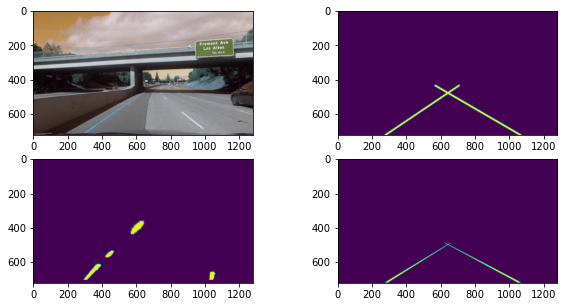

In [51]:
line_image = display_lines(im_warp, averaged_lines) 
warp_line = getPerspectiveTransform(line_image,True)


fx, plts = plt.subplots(2,2,figsize = (10,5))
plts[0][0].imshow(frame)
plts[0][1].imshow(line_image)
plts[1][0].imshow(im_warp)
plts[1][1].imshow(warp_line)
# plt.imshow(im_warp)

# Do the line Trace with distribution curves

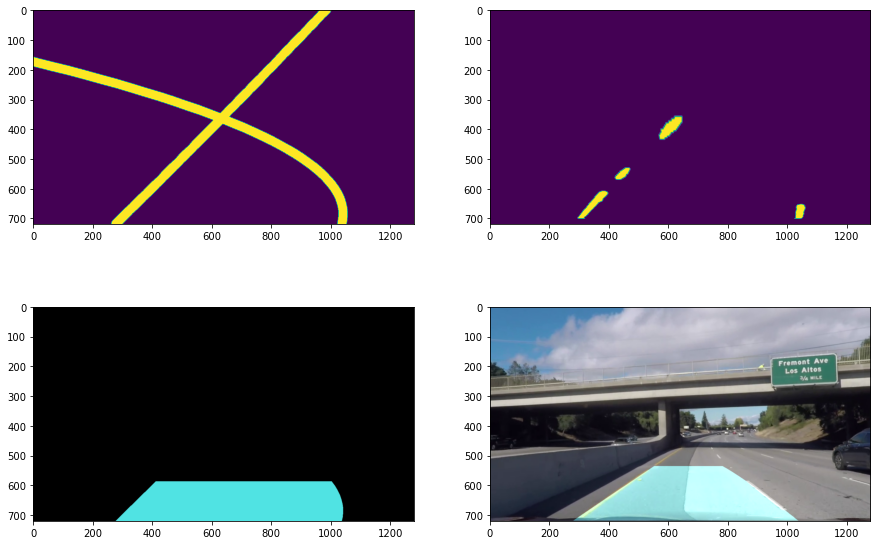

In [43]:
frame = imgs[100]

height,width = im_warp.shape
half_width =int(im_warp.shape[1]//2) 

im_binary = getLaneMask(frame,Lanemodel,laneParams)
im_warp = getPerspectiveTransform(im_binary)

im_warpLEFT = im_warp[:,:half_width] # find bottom half of the warped road
im_warpRIGHT = im_warp[:,half_width:] # find bottom half of the warped road

lY,lX = im_warpLEFT.nonzero()
rY,rX = im_warpRIGHT.nonzero()

rX = [(i+half_width) for i in rX]

left_curve, right_curve = np.poly1d(np.polyfit(lY,lX,2)), np.poly1d(np.polyfit(rY,rX,2))

# Laxis,Raxis = np.linspace(lY.min(),lX.max()-1), np.linspace(rY.min(),rX.max()-1)
Laxis = Raxis = np.linspace(0,height)

# fit the polynomial coefficents with the linear space
l_fit,r_fit = left_curve(Laxis),right_curve(Laxis)

L_line, R_line = np.dstack((l_fit.astype(np.int32),Laxis.astype(np.int32))), np.dstack((r_fit.astype(np.int32),Raxis.astype(np.int32)))

# Visualisation works 

# line = getDirection(L_line,R_line) # get the center line with mean of left and right lanes.
imLines = drawLaneLines(im_warp,L_line,R_line) # draw the estimated lane line 

imL = np.zeros(imLines.shape, dtype=np.uint8)
imL = np.dstack((imL,imL,imL))
l1,r1 = np.squeeze(L_line)[-10:],np.flipud(np.squeeze(R_line)[-10:]) # get the last 15 points of left and right lines in right order
pts = np.vstack((l1,r1)) # stack then in correct order
imColorLane = cv2.fillPoly(imL, [pts], (80,227, 227)) #get ColorLanes
inv_imColorLane= getPerspectiveTransform(imColorLane,True)
inv_imColorLane = cv2.addWeighted(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), 1, inv_imColorLane, 0.5, 0)

fx,plts = plt.subplots(2,2,figsize = (15,10))
plts[0][0].imshow(imLines)
plts[0][1].imshow(im_warp)
plts[1][0].imshow(imL)
plts[1][1].imshow(inv_imColorLane)

In [91]:
def ProcessLaneVideo(vidtype, path ="/home/gokul/Projects/LaneDetection/Input/"):
    outputs = []
    if vidtype == 'Challenge':
        video = path + 'challenge_video.mp4'
    elif vidtype == 'Project':
        video = path + 'project_video.mp4'
    else:
        print('Improper video type')
    cap = cv2.VideoCapture(video)
    while(True):
        ret, frame = cap.read()
        if ret:
#             frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
            frame =  cv2.undistort(frame, mtx, dist, None, mtx)
            outputs.append(processLane(frame))
        else:
            break
    cap.release()
    outVideo = mpy.ImageSequenceClip(outputs, fps=25)
    
    return imgs


outVideo = ProcessLaneVideo('Project')
outVideo.write_videofile('output.mp4')



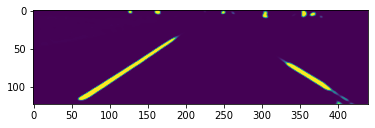

In [93]:
plt.imshow(out)

# Train my own model:

In [34]:
height,width = frame.shape[:2]
## lane crop:
laneParams = {'y_min' : 420 ,'y_max': 690,
'x_min':200, 'x_max' : width-200,
'scaling' : 2, 'presence_weight': 50.0}

carParams = {'y_min' : 420 ,'y_max': 690,
'x_min':0, 'x_max' : width-200,
'scaling' : 2, 'presence_weight': 50.0}

# CNN Lane Model
with custom activation and loss function


In [5]:
def CarLaneModel(params):
    model = Sequential()
    # Convolution2D(output_depth, convolution height, convolution_width, ...)
    model.add(Convolution2D(20, 5, 5, border_mode='same',
            input_shape=(int((params['y_max'] - params['y_min']) / params['scaling']),
                         int((params['x_max'] - params['x_min']) / params['scaling']),
                         3)))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(30, 5, 5, border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(30, 5, 5, border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(30, 5, 5, border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(20, 5, 5, border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(10, 5, 5, border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(1, 5, 5, border_mode='same', W_regularizer=l2(0.01), activation=tanh_mod))

    
    model.compile(optimizer = 'adam',
            loss = weighted_binary_crossentropy(params['presence_weight']),
            metrics = ['binary_accuracy', 'binary_crossentropy'])
    return model

def weighted_binary_crossentropy(weight):
    """Higher weights increase the importance of examples in which
     the correct answer is 1. Higher values should be used when
     1 is a rare answer. Lower values should be used when 0 is
     a rare answer."""
    return (lambda y_true, y_pred: tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, weight))

def tanh_mod(x):
    """Actually [0.05, 0.95] to avoid divide by zero errors"""

    tanh_offset = tf.constant(0.5)
    tanh_scale = tf.constant(0.45)
    return (tf.tanh(x) * tanh_scale) + tanh_offset    



In [6]:
LaneModel = CarLaneModel(laneParams)


LaneModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 123, 440, 20)      1520      
_________________________________________________________________
batch_normalization_1 (Batch (None, 123, 440, 20)      80        
_________________________________________________________________
activation_1 (Activation)    (None, 123, 440, 20)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 123, 440, 20)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 123, 440, 30)      15030     
_________________________________________________________________
batch_normalization_2 (Batch (None, 123, 440, 30)      120       
_________________________________________________________________
activation_2 (Activation)    (None, 123, 440, 30)     

## Pytorch Implementation

In [ ]:
import torch.nn as nn
from torch.autograd import Variable

class LaneDetector(nn.Module):
    def __init__(self):
        super(LaneDetector, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 20,kernel_size=(5,5), border),  
            nn.ReLU(True),
            nn.Conv2d(30, 30, kernel_size=(5,5), stride=2, padding=1),  
            nn.ReLU(True),
            nn.Conv2d(30, 30, kernel_size=(5,5), stride=2, padding=1),  
            nn.ReLU(True),
            nn.Conv2d(30, 20, kernel_size=(5,5), stride=2, padding=1),  
            nn.ReLU(True),
            nn.Conv2d(20, 10, kernel_size=(5,5), stride=2, padding=1),  
            nn.ReLU(True)
            nn.Conv2d(10, 1, kernel_size=(5,5), stride=2, padding=1),  
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x